# Modeling a Single Hexagonal Assembly

This notebook is intended to demonstrate how to use ROBIN3's [Python API](../pythonapi/index.rst) to simulate a single hexagonal assembly. 

In [2]:
%matplotlib inline
import numpy as np
import robin3
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
robin3.config.USE_TQDM_NOTEBOOK = True

## Defining Materials

Here we create a [material](../io_formats/input.rst#material-object) list containing 3 kinds of material:
    1. Normal 3.6% enriched UO2 fuel material;
    1. Normal 4.0% enriched UO2 fuel material;
    2. Gd-bearing fuel material composed by 5% Gd2O3 and 95% 3.3%-enriched UO2.
Note "GD2O3" is pre-defined in the [material databank file](../io_formats/materialdb.rst), which can be inspected by [robin3.get_predefined_materials](../pythonapi/generated/robin3.get_predefined_materials.rst) as well.

In [3]:
materials = [
    {
        "name": "UO2_400",
        "elements": ["UO2_4.0"],
        "weight_percents": [1.0],
        "density": 10.3
    },
    {
        "name": "UO2_360",
        "elements": ["UO2_3.6"],
        "weight_percents": [1.0],
        "density": 10.3
    },
    {
        "name": "Gd_bearing_fuel",
        "elements": ["UO2_3.3", "GD2O3"],
        "weight_percents": [0.95, 0.05],
        "density": 9.4
    }
]

## Defining Pin Structures

First we use [structure](../io_formats/input.rst#structure-object) to define 2 normal fuel pins with different enrichment and a guide tube.

In [4]:
fuel_pin_36 = {
    "name": "F36",
    "primitives": [
        {"type": "CIRCLE", "radius": 0.3785},
        {"type": "CIRCLE", "radius": 0.3865},
        {"type": "CIRCLE", "radius": 0.4550},
    ],
    "regions": [
        {"material": "UO2_360", "space": "1"},
        {"material": "HE", "space": "2-1"},
        {"material": "ZIRLO", "space": "3-2"},
    ]
}
fuel_pin_40 = {
    "name": "F40",
    "primitives": [
        {"type": "CIRCLE", "radius": 0.3785},
        {"type": "CIRCLE", "radius": 0.3865},
        {"type": "CIRCLE", "radius": 0.4550},
    ],
    "regions": [
        {"material": "UO2_400", "space": "1"},
        {"material": "HE", "space": "2-1"},
        {"material": "ZIRLO", "space": "3-2"},
    ]
}
guide_tube = {
    "name": "GT",
    "primitives": [
        {"type": "CIRCLE", "radius": 0.55},
        {"type": "CIRCLE", "radius": 0.65},
    ],
    "regions": [
        {"material": "MOD", "space": "1"},
        {"material": "ZIRLO", "space": "2-1"},
    ]
}

Note here material "MOD" is a build-in material, and material "HE" and "ZIRLO" are pre-defined in ROBIN3's [material databank file](../io_formats/materialdb.rst), which can be inspected by [robin3.get_predefined_materials](../pythonapi/generated/robin3.get_predefined_materials.rst) as well.

Second we define the Gd-bearing fuel pin, Gd-bearing fuel pin is same as the normal fuel pin except the material in the inner fuel region, so we can copy from the normal fuel pin and override the inner regions definition. Due to the large absorption cross section of Gd isotopes, Gd-bearing pin should be take special consideration for [meshing](../io_formats/input.rst#meshing-object). Instead of using the default [meshing](../io_formats/input.rst#meshing-object), we redefine the [meshing](../io_formats/input.rst#meshing-object) with 10 equal-area rings divided by the radii of meshing.

In [5]:
import copy
import pprint
gd_pin = copy.deepcopy(fuel_pin_36)
gd_pin["name"] = "B33"
gd_pin["regions"][0]["material"] = "Gd_bearing_fuel"
gd_pin["meshing"] = {"type": "SECTORS", 
                     "num_azimuths": 6,
                     "radii": [np.sqrt(0.3785**2 / 10 * (n+1)) for n in range(9)]}
pprint.pprint(gd_pin)

{'meshing': {'num_azimuths': 6,
             'radii': [0.11969220943737316,
                       0.1692703458967341,
                       0.20731298801570539,
                       0.23938441887474632,
                       0.26763991667910825,
                       0.2931848393079015,
                       0.3166758200431476,
                       0.3385406917934682,
                       0.3590766283121195],
             'type': 'SECTORS'},
 'name': 'B33',
 'primitives': [{'radius': 0.3785, 'type': 'CIRCLE'},
                {'radius': 0.3865, 'type': 'CIRCLE'},
                {'radius': 0.455, 'type': 'CIRCLE'}],
 'regions': [{'material': 'Gd_bearing_fuel', 'space': '1'},
             {'material': 'HE', 'space': '2-1'},
             {'material': 'ZIRLO', 'space': '3-2'}]}


The hexagonal assembly we are modeling has stiffening plates in the corner edges, demonstrate ![stiffening plates](../_images/vver_stiffening_plates.png)

In order to model this geometry we can create a plate structure then put it to the assembly, here we define the plate [structure](../io_formats/input.rst#structure-object):

In [6]:
plate = {
    "name": "plate",
    "primitives": [
        {"type": "POLYGON", 
         "vertexes": [
            {"x": -13.5100, "y":  0.0},
            {"x":  13.5100, "y":  0.0},
            {"x":  -6.7550, "y":  11.7000},
            {"x":   6.7550, "y":  11.7000},
            {"x":  -6.7550, "y": -11.7000},
            {"x":   6.7550, "y": -11.7000},
        ]},
        {"type": "POLYGON", 
         "vertexes": [
            {"x": -13.3945, "y":  0.0},
            {"x":  13.3945, "y":  0.0},
            {"x":  -6.6973, "y":  11.6000},
            {"x":   6.6973, "y":  11.6000},
            {"x":  -6.6973, "y": -11.6000},
            {"x":   6.6973, "y": -11.6000},
        ]},
        {"type": "POLYGON", 
         "vertexes": [
            {"x": -12.1316, "y":  2.5875},
            {"x":  -8.3066, "y":  9.2125},
            {"x":  12.1316, "y": -2.5875},
            {"x":   8.3066, "y": -9.2125},
        ]},
        {"type": "POLYGON", 
         "vertexes": [
            {"x":  12.1316, "y":  2.5875},
            {"x":   8.3066, "y":  9.2125},
            {"x": -12.1316, "y": -2.5875},
            {"x":  -8.3066, "y": -9.2125},
        ]},
        {"type": "POLYGON", 
         "vertexes": [
            {"x": -3.8250, "y":  11.8000},
            {"x":  3.8250, "y":  11.8000},
            {"x": -3.8250, "y": -11.8000},
            {"x":  3.8250, "y": -11.8000},
        ]},
    ],
    "regions": [
        {"material": "ZIRLO", "space": '1-2-3-4-5'}
    ]
}

## Defining Assembly

Defining the hexagonal [assembly](../io_formats/input.rst#assembly-object). This assembly has 243 4.0% enrichment fuel pins, 60 3.6% enrichment fuel pins and 9 Gd-bearing fuel pins. Note that we put the plate structure by defining structure locations.

In [7]:
assembly = {
    "name": "single_hexagonal_assembly",
    "type": "HEXAGON",
    "symmetry": 1,
    "pitch": 23.6,
    "cell_pitch": 1.275,
    "cell_map": [ 
                                  "F36","F36","F36","F36","F36","F36","F36","F36","F36","F36","F36",
                               "F36","F40","F40","F40","F40","F40","F40","F40","F40","F40","F40","F36",
                            "F36","F40","B33","F40","F40","F40","F40","F40","F40","F40","B33","F40","F36",
                         "F36","F40","F40","F40","F40","F40","F40","F40","F40","F40","F40","F40","F40","F36",
                      "F36","F40","F40","F40","F40","F40","F40","GT", "F40","F40","F40","F40","F40","F40","F36",
                   "F36","F40","F40","F40","F40","GT", "F40","F40","F40","F40","GT", "F40","F40","F40","F40","F36",
                "F36","F40","F40","F40","F40","F40","F40","F40","F40","B33","F40","F40","F40","F40","F40","F40","F36",
             "F36","F40","F40","F40","GT", "F40","F40","F40","GT", "F40","F40","F40","F40","GT", "F40","F40","F40","F36",
          "F36","F40","F40","F40","F40","F40","F40","F40","F40","F40","F40","GT", "F40","F40","F40","F40","F40","F40","F36",
       "F36","F40","F40","F40","F40","F40","F40","GT", "F40","F40","F40","F40","F40","F40","F40","F40","F40","F40","F40","F36",
    "F36","F40","B33","F40","F40","GT", "F40","F40","F40","F40","GT", "F40","F40","F40","F40","GT", "F40","F40","B33","F40","F36",
       "F36","F40","F40","F40","F40","F40","B33","F40","F40","F40","F40","F40","GT", "F40","F40","F40","F40","F40","F40","F36",
          "F36","F40","F40","F40","F40","F40","F40","GT", "F40","F40","F40","F40","F40","F40","F40","F40","F40","F40","F36",
             "F36","F40","F40","F40","GT", "F40","F40","F40","F40","GT", "F40","B33","F40","GT", "F40","F40","F40","F36",
                "F36","F40","F40","F40","F40","F40","F40","F40","F40","F40","F40","F40","F40","F40","F40","F40","F36",
                   "F36","F40","F40","F40","F40","GT", "F40","F40","F40","F40","GT", "F40","F40","F40","F40","F36",
                      "F36","F40","F40","F40","F40","F40","F40","GT", "F40","F40","F40","F40","F40","F40","F36",
                         "F36","F40","F40","F40","F40","F40","F40","F40","F40","F40","F40","F40","F40","F36",
                            "F36","F40","B33","F40","F40","F40","F40","F40","F40","F40","B33","F40","F36",
                               "F36","F40","F40","F40","F40","F40","F40","F40","F40","F40","F40","F36",
                                  "F36","F36","F36","F36","F36","F36","F36","F36","F36","F36","F36"
    ],
    "structure_location": [{"structure": "plate", "location": {"x": 0.0, "y": 0.0}}]
}

## Defining State Points

[State points](../io_formats/input.rst#state-points-object) is required for micro xs cases, here we provides burnup points and power density to perform single assembly depletion calculation:

In [8]:
state_points = {
    "boron_concentration": 500,
    "moderator_temperature": 577,
    "fuel_temperature": 903,
    "system_pressure": 15.51,
    "burnup_points":[0.0,0.03,0.1,0.5,1,2,3,4,5,6,7,8,9,10,12,14,16,18,20,
                     22,24,26,28,30,32,34,36,38,40,42,44,46,48,50],
    "power_density": 40.0
}

## Composing a Input Model

The full [input model](../io_formats/input.rst) for a typical single assembly depletion calculation includes following parts:
    1. [materials](../io_formats/input.rst#materials-array);
    2. [structures](../io_formats/input.rst#structures-array);
    3. [assemblies](../io_formats/input.rst#assemblies-array);
    4. [state points](../io_formats/input.rst#state-points-object).

In [9]:
model = {
    "materials": materials,
    "structures": [fuel_pin_36, fuel_pin_40, guide_tube, gd_pin, plate],
    "assemblies": [assembly],
    "state_points": state_points
}

## Visualizing Input Model

Instantiates a [robin3.Plotter](../pythonapi/generated/robin3.Plotter.rst) to visualize the model

In [10]:
plotter = robin3.Plotter(model)

Display our single assembly by plot_geometry method:

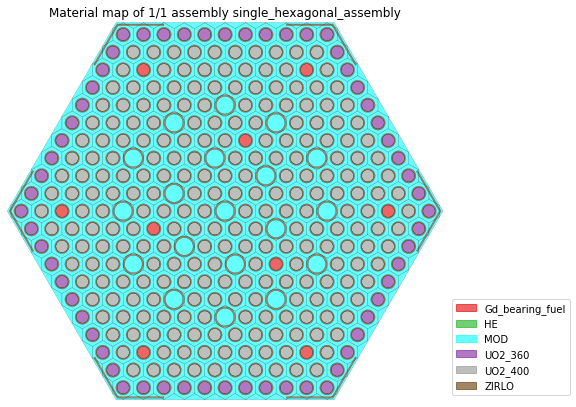

In [11]:
fig = plotter.plot_geometry()

Display our single pin cell assembly with MOC meshing, here we can see the Gd-bearing pins are finely divided. 

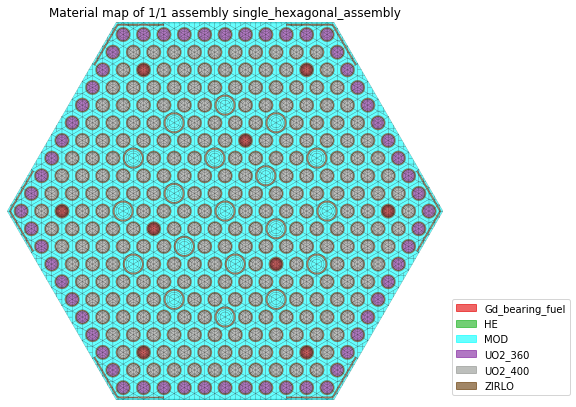

In [12]:
fig = plotter.plot_geometry(show_meshes=True)

Display flat source regions:

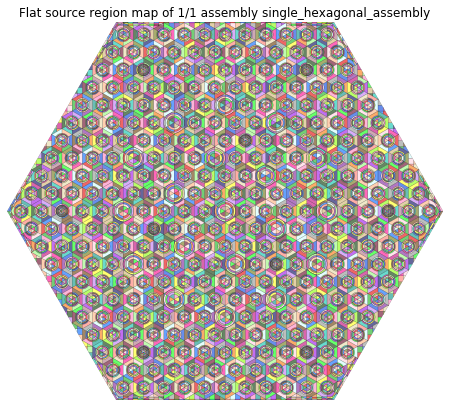

In [13]:
fig = plotter.plot_flat_source_regions()

## Run ROBIN3

Running ROBIN3 from Python can be done using the [robin3.run()](../pythonapi/generated/robin3.run.rst) function. This function allows you to use GPU by setting use_GPU=True if it needed, GPU will significantly reduce the running time.

In [14]:
result = robin3.run(model, use_gpu=True)

In [15]:
print(result)

The [robin3.run()](../pythonapi/generated/robin3.run.rst) function return a [robin3.ResultProcessor](../pythonapi/generated/robin3.ResultProcessor.rst) instance. All the result data can be accessed by the result_data attribute, and the result data are saved by a HDF5 file named by
result_file attribute, summary result data such as keff can be inspected by method summary which return a pandas DataFrame.

In [16]:
print(result.result_file)
df = result.summary()
print(df)

/home/ghchen/Nustar/projects/robin3/docs/source/examples/single_hexagonal_assembly.h5
    burnup    tmo    tfu    bor      keff      kinf  keff_apply_buckling  \
0     0.00  577.0  903.0  500.0  1.225599  1.225571             1.225439   
1     0.03  577.0  903.0  500.0  1.197515  1.197298             1.197158   
2     0.10  577.0  903.0  500.0  1.187905  1.187720             1.187568   
3     0.50  577.0  903.0  500.0  1.181392  1.181509             1.181339   
4     1.00  577.0  903.0  500.0  1.178635  1.178902             1.178730   
5     2.00  577.0  903.0  500.0  1.176167  1.176539             1.176367   
6     3.00  577.0  903.0  500.0  1.173328  1.173846             1.173671   
7     4.00  577.0  903.0  500.0  1.170285  1.170874             1.170697   
8     5.00  577.0  903.0  500.0  1.167357  1.167967             1.167788   
9     6.00  577.0  903.0  500.0  1.164761  1.165349             1.165166   
10    7.00  577.0  903.0  500.0  1.162551  1.163140             1.162953   
11

We can conveniently plot k-effective and peak pin power changes with burnup by using pandas:

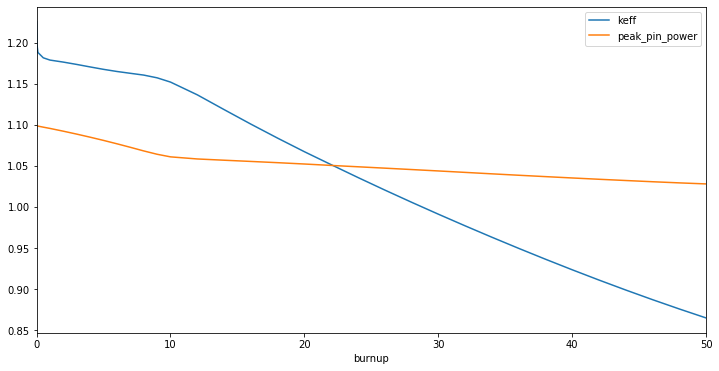

In [17]:
import pandas as pd
df.plot(x="burnup", y=["keff", "peak_pin_power"])

## Result Visualization

Result visualization from Python can be done using a [robin3.Plotter](../pythonapi/generated/robin3.Plotter.rst) instance generate by [ResultProcessor](../pythonapi/generated/robin3.ResultProcessor.rst)'s method generate_plotter.

In [18]:
plotter = result.generate_plotter()

Here we can plot input model as well:

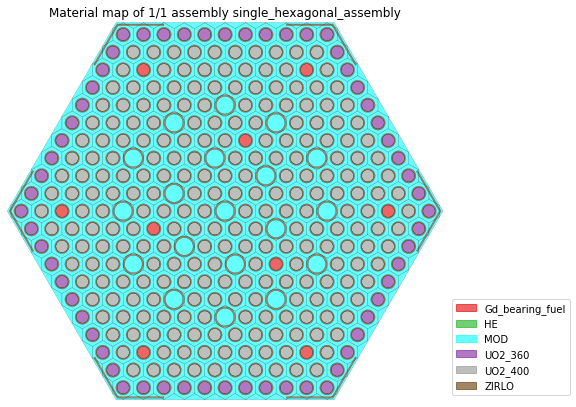

In [19]:
fig = plotter.plot_geometry()

Display depletion and resonance regions:

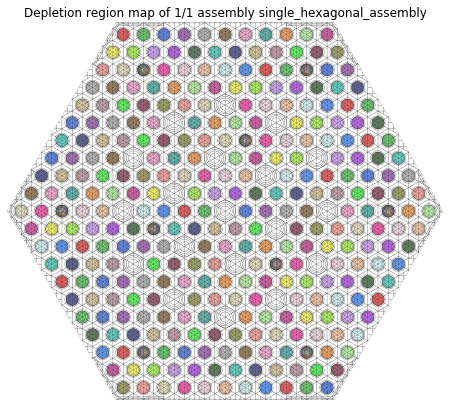

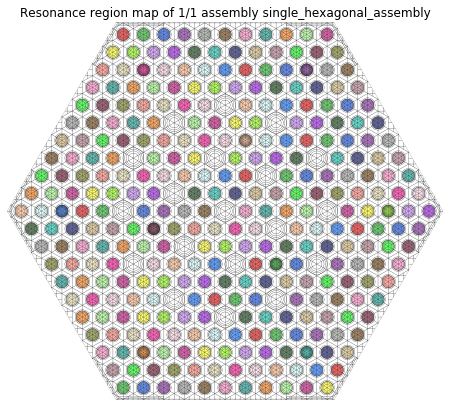

In [20]:
fig = plotter.plot_depletion_regions()
fig = plotter.plot_resonance_regions()

Unlike normal fuel pin, the fine flat source region will be used as depletion regions for Gd-bearing fuel pins to precisely modeling Gd burning. So we can see different region division in above figures in the Gd-bearing fuel pin.

From the output file, many result items can be displayed by the [robin3.Plotter](../pythonapi/generated/robin3.Plotter.rst) Class. For example, we can plot the pin power distribution at any burnup points that we calculated by plot_pin_power method, here we display power distribution at the begining and the end.

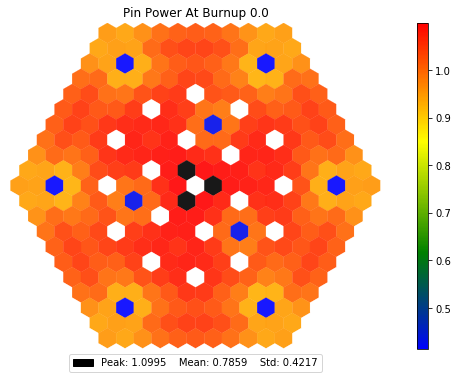

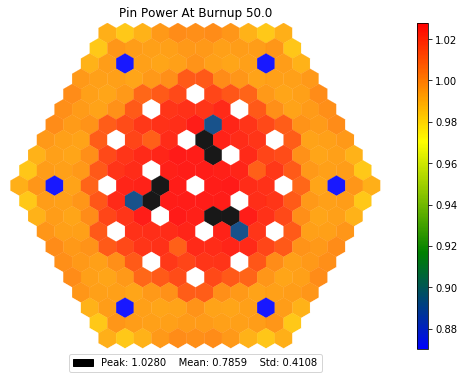

In [21]:
fig = plotter.plot_pin_power(burnup=0.0)
fig = plotter.plot_pin_power(burnup=50.0)

Visualize the mesh flux distribution of energy group 1 (fast group) and 2 (thermal group) at burnup 0.0 and 50.0 GWd/tU, here we can find sigificant different between 0.0 GWd/tU and 50.0 GWd/tU cause the Gd isotopes have totally burned out at the 50.0GWd/tU point. 

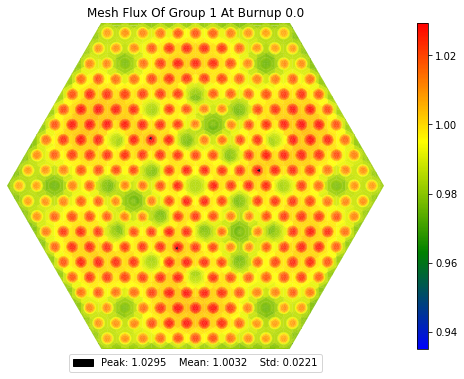

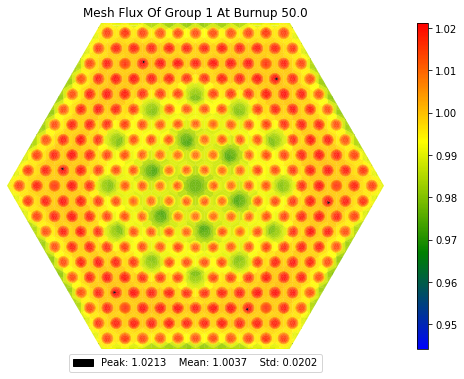

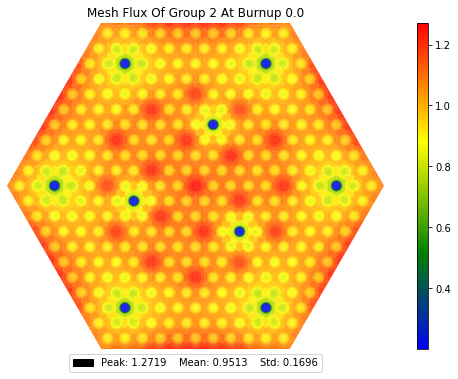

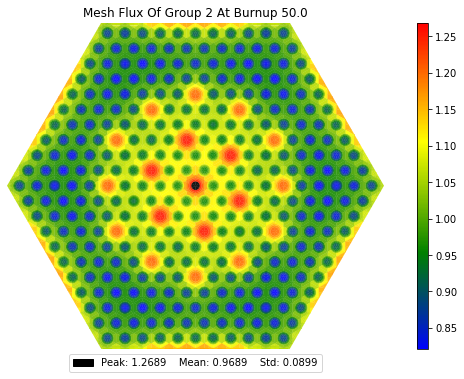

In [22]:
for g in [1, 2]:
    fig = plotter.plot_mesh_flux(group=g, burnup=0.0)
    fig = plotter.plot_mesh_flux(group=g, burnup=50.0)